# 1. Import and Install Dependencies

In [101]:
# !pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [102]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, GRU, Dense, 
    Dropout, BatchNormalization, TimeDistributed,
    Input, Reshape, GlobalAveragePooling2D
)
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.18.0
GPU Available: []


# 2. Setup MediaPipe Holistic for Keypoint Detection

In [103]:
mp_holistic = mp.solutions.holistic  # Holistic Model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

In [104]:
def mediapipe_detection(image, model):
    """Perform MediaPipe detection on image"""
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [105]:
def draw_styled_landmarks(image, results):
    """Draw landmarks on image"""
    # Draw pose
    mp_drawing.draw_landmarks(
        image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(250, 250, 250), thickness=2, circle_radius=2),
        mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
    )
    # Draw hands
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

# 3. Extract Hand Keypoints for CNN Input

**CNN-GRU requires structured hand data:**
- Left Hand: 21 landmarks × 3 coordinates = (21, 3)
- Right Hand: 21 landmarks × 3 coordinates = (21, 3)
- Combined: (42, 3) or separate (21, 3) per hand

In [106]:
def extract_hand_keypoints_for_cnn(results):
    """
    Extract hand landmarks in structured format for CNN processing
    Returns: (42, 3) array - both hands concatenated
    """
    # Left hand: 21 landmarks × 3 coords
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) \
        if results.left_hand_landmarks else np.zeros((21, 3))
    
    # Right hand: 21 landmarks × 3 coords
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) \
        if results.right_hand_landmarks else np.zeros((21, 3))
    
    # Concatenate both hands: (42, 3)
    hands_combined = np.vstack([lh, rh])
    
    return hands_combined

In [107]:
# Test extraction
# This creates a dummy result to show the shape
class DummyLandmark:
    def __init__(self):
        self.x, self.y, self.z = 0.0, 0.0, 0.0

class DummyResults:
    def __init__(self):
        self.left_hand_landmarks = None
        self.right_hand_landmarks = None

dummy = DummyResults()
test_keypoints = extract_hand_keypoints_for_cnn(dummy)
print(f"Hand keypoints shape: {test_keypoints.shape}")  # Should be (42, 3)
print(f"Expected input per frame: (42, 3)")

Hand keypoints shape: (42, 3)
Expected input per frame: (42, 3)


# 4. Setup Data Paths and Load External Dataset

In [108]:
# Path to external data
DATA_PATH = os.path.join('..', 'new_models', 'Data')

# Check if folder exists
if os.path.isdir(DATA_PATH):
    print("Data folder found:", DATA_PATH)
else:
    print("Data folder NOT found:", DATA_PATH)
    print("Please update DATA_PATH to point to your .npy files")

Data folder found: ..\new_models\Data


In [109]:
# Get all action folders
action_folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]
actions = np.array(sorted(action_folders))

print(f"Found {len(actions)} actions in the dataset:")
print(actions)

Found 15 actions in the dataset:
['---' 'akarere' 'akazi' 'amakuru' 'bayi' 'bibi' 'igihugu' 'neza'
 'nyarugenge' 'oya' 'papa' 'umujyi wa kigali' 'umurenge' 'urakoze' 'yego']


In [110]:
# Auto-detect dataset parameters
sample_action = actions[0]
sample_path = os.path.join(DATA_PATH, sample_action)
sequences_in_action = [d for d in os.listdir(sample_path) if os.path.isdir(os.path.join(sample_path, d))]
no_sequences = len(sequences_in_action)

# Check frames in first sequence
first_sequence_path = os.path.join(sample_path, sequences_in_action[0])
npy_files = [f for f in os.listdir(first_sequence_path) if f.endswith('.npy')]
sequence_length = len(npy_files)

print(f"\nDataset Information:")
print(f"  - Number of actions: {len(actions)}")
print(f"  - Sequences per action: {no_sequences}")
print(f"  - Frames per sequence: {sequence_length}")
print(f"  - Total videos: {len(actions) * no_sequences}")


Dataset Information:
  - Number of actions: 15
  - Sequences per action: 40
  - Frames per sequence: 30
  - Total videos: 600


# 5. Data Inspection

In [111]:
print("=" * 70)
print("DATA STRUCTURE INSPECTION")
print("=" * 70)

for action in actions[:3]:  # Check first 3 actions
    action_path = os.path.join(DATA_PATH, action)
    sequences = sorted([d for d in os.listdir(action_path) if os.path.isdir(os.path.join(action_path, d))])
    
    print(f"\nAction: {action}")
    print(f"  Total sequences: {len(sequences)}")
    
    if sequences:
        first_seq_path = os.path.join(action_path, sequences[0])
        npy_files = sorted([f for f in os.listdir(first_seq_path) if f.endswith('.npy')])
        
        print(f"  First sequence: {sequences[0]}")
        print(f"    Number of .npy files: {len(npy_files)}")
        
        if npy_files:
            sample_file = os.path.join(first_seq_path, npy_files[0])
            sample_data = np.load(sample_file)
            print(f"    Sample file shape: {sample_data.shape}")

print("\n" + "=" * 70)

DATA STRUCTURE INSPECTION

Action: ---
  Total sequences: 40
  First sequence: 1
    Number of .npy files: 30
    Sample file shape: (1518,)

Action: akarere
  Total sequences: 40
  First sequence: 1
    Number of .npy files: 30
    Sample file shape: (1518,)

Action: akazi
  Total sequences: 40
  First sequence: 1
    Number of .npy files: 30
    Sample file shape: (1518,)



# 6. Preprocess Data for CNN-GRU

**Important:** We need to reshape the data to (42, 3) per frame for CNN processing

In [112]:
def reshape_for_cnn(flat_keypoints):
    """
    Reshape flattened keypoints to (42, 3) format for CNN
    Input: 1D array from .npy file
    Output: (42, 3) array - both hands structured
    """
    # Expected: pose (132) + lh (63) + rh (63) + magnified hands...
    # For CNN, we only need hands: extract hand portions
    
    # Skip pose (first 132 values)
    # Extract left hand (next 63 values) and right hand (next 63)
    pose_size = 132
    hand_size = 63  # 21 landmarks × 3 coords
    
    lh_flat = flat_keypoints[pose_size:pose_size + hand_size]
    rh_flat = flat_keypoints[pose_size + hand_size:pose_size + 2*hand_size]
    
    # Reshape to (21, 3)
    lh = lh_flat.reshape(21, 3)
    rh = rh_flat.reshape(21, 3)
    
    # Combine: (42, 3)
    hands_combined = np.vstack([lh, rh])
    
    return hands_combined

In [113]:
# Create label map
label_map = {label: num for num, label in enumerate(actions)}
print("Label Mapping:")
for label, num in label_map.items():
    print(f"  {num}: {label}")

Label Mapping:
  0: ---
  1: akarere
  2: akazi
  3: amakuru
  4: bayi
  5: bibi
  6: igihugu
  7: neza
  8: nyarugenge
  9: oya
  10: papa
  11: umujyi wa kigali
  12: umurenge
  13: urakoze
  14: yego


In [114]:
# Load sequences and labels
sequences, labels = [], []
missing_data = []
padded_sequences = []
truncated_sequences = []

print("\nLoading data...")
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    
    # Get all sequence folders
    sequence_folders = sorted([d for d in os.listdir(action_path) 
                               if os.path.isdir(os.path.join(action_path, d))])
    
    for sequence_folder in sequence_folders:
        sequence_path = os.path.join(action_path, sequence_folder)
        window = []
        
        try:
            # Get all .npy files in sequence
            npy_files = sorted([f for f in os.listdir(sequence_path) if f.endswith('.npy')])
            
            # Check if sequence length matches
            actual_length = len(npy_files)
            
            # Load each frame and reshape for CNN
            for npy_file in npy_files:
                npy_path = os.path.join(sequence_path, npy_file)
                flat_data = np.load(npy_path)
                
                # Reshape to (42, 3) for CNN
                structured_data = reshape_for_cnn(flat_data)
                window.append(structured_data)
            
            # Handle different sequence lengths
            if actual_length < sequence_length:
                # PAD: Add last frame to match sequence_length
                padding_needed = sequence_length - actual_length
                last_frame = window[-1] if window else np.zeros((42, 3))
                for _ in range(padding_needed):
                    window.append(last_frame.copy())
                padded_sequences.append(f"{action}/{sequence_folder} - Padded {padding_needed} frames")
                
            elif actual_length > sequence_length:
                # TRUNCATE: Keep only first sequence_length frames
                window = window[:sequence_length]
                truncated_sequences.append(f"{action}/{sequence_folder} - Truncated from {actual_length} to {sequence_length}")
            
            # Add to sequences (all data included now)
            sequences.append(window)
            labels.append(label_map[action])
            
        except Exception as e:
            missing_data.append(f"{action}/{sequence_folder} - Error: {str(e)}")
            continue

print(f"\n{'='*70}")
print(f"DATA LOADING SUMMARY")
print(f"{'='*70}")
print(f"✓ Loaded {len(sequences)} sequences successfully")
print(f"  - Padded sequences: {len(padded_sequences)}")
print(f"  - Truncated sequences: {len(truncated_sequences)}")
print(f"  - Failed sequences: {len(missing_data)}")

if padded_sequences:
    print(f"\nPadded Sequences (first 5):")
    for item in padded_sequences[:5]:
        print(f"  • {item}")
    if len(padded_sequences) > 5:
        print(f"  ... and {len(padded_sequences) - 5} more")

if truncated_sequences:
    print(f"\nTruncated Sequences (first 5):")
    for item in truncated_sequences[:5]:
        print(f"  • {item}")
    if len(truncated_sequences) > 5:
        print(f"  ... and {len(truncated_sequences) - 5} more")

if missing_data:
    print(f"\n⚠️ Failed to Load ({len(missing_data)} sequences):")
    for item in missing_data[:10]:
        print(f"  ✗ {item}")
    if len(missing_data) > 10:
        print(f"  ... and {len(missing_data) - 10} more")

print(f"\n{'='*70}")


Loading data...

DATA LOADING SUMMARY
✓ Loaded 600 sequences successfully
  - Padded sequences: 0
  - Truncated sequences: 249
  - Failed sequences: 0

Truncated Sequences (first 5):
  • nyarugenge/1 - Truncated from 60 to 30
  • nyarugenge/10 - Truncated from 60 to 30
  • nyarugenge/11 - Truncated from 60 to 30
  • nyarugenge/12 - Truncated from 60 to 30
  • nyarugenge/13 - Truncated from 60 to 30
  ... and 244 more


DATA LOADING SUMMARY
✓ Loaded 600 sequences successfully
  - Padded sequences: 0
  - Truncated sequences: 249
  - Failed sequences: 0

Truncated Sequences (first 5):
  • nyarugenge/1 - Truncated from 60 to 30
  • nyarugenge/10 - Truncated from 60 to 30
  • nyarugenge/11 - Truncated from 60 to 30
  • nyarugenge/12 - Truncated from 60 to 30
  • nyarugenge/13 - Truncated from 60 to 30
  ... and 244 more



# 7. Verify Data Shape and Split

In [115]:
# Convert to numpy arrays
X = np.array(sequences)
y = to_categorical(labels).astype(int)

print(f"\nData Shapes:")
print(f"  X (features): {X.shape}")  # Expected: (num_sequences, 30, 42, 3)
print(f"  y (labels): {y.shape}")     # Expected: (num_sequences, num_classes)

# Verify shape
if len(X.shape) == 4:
    print(f"\n✓ Correct shape for CNN-GRU: (samples, timesteps, height, width)")
    print(f"  - Samples: {X.shape[0]}")
    print(f"  - Timesteps: {X.shape[1]}")
    print(f"  - Hand landmarks: {X.shape[2]}")
    print(f"  - Coordinates: {X.shape[3]}")
else:
    print(f"\nWarning: Unexpected shape! Please verify data preprocessing.")


Data Shapes:
  X (features): (600, 30, 42, 3)
  y (labels): (600, 15)

✓ Correct shape for CNN-GRU: (samples, timesteps, height, width)
  - Samples: 600
  - Timesteps: 30
  - Hand landmarks: 42
  - Coordinates: 3


In [116]:
# Label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print("\nLabel Distribution:")
for label_idx, count in zip(unique_labels, counts):
    action_name = actions[label_idx]
    print(f"  {action_name}: {count} sequences")


Label Distribution:
  ---: 40 sequences
  akarere: 40 sequences
  akazi: 40 sequences
  amakuru: 40 sequences
  bayi: 40 sequences
  bibi: 40 sequences
  igihugu: 40 sequences
  neza: 40 sequences
  nyarugenge: 40 sequences
  oya: 40 sequences
  papa: 40 sequences
  umujyi wa kigali: 40 sequences
  umurenge: 40 sequences
  urakoze: 40 sequences
  yego: 40 sequences


In [117]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=labels
)

print(f"\nTrain-Test Split:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")
print(f"  Split ratio: 80-20")


Train-Test Split:
  Training samples: 480
  Testing samples: 120
  Split ratio: 80-20


# 8. Build CNN-GRU Model Architecture

## Architecture Flow:
1. **Input**: (timesteps, 42, 3) - sequences of hand landmarks
2. **TimeDistributed CNN**: Extract spatial features from each frame
3. **GRU Layers**: Capture temporal dependencies
4. **Dense Layers**: Classification head
5. **Output**: Softmax over action classes

In [118]:
def build_cnn_gru_model(timesteps, height, width, num_classes):
    """
    REVISED CNN-GRU model with improved architecture
    
    Args:
        timesteps: Number of frames per sequence (e.g., 30)
        height: Number of landmarks (e.g., 42 for both hands)
        width: Coordinates per landmark (e.g., 3 for x, y, z)
        num_classes: Number of sign classes
    
    Returns:
        Compiled Keras model
    """
    
    inputs = Input(shape=(timesteps, height, width), name='hand_sequence')
    
    # Reshape to add channel dimension for CNN
    # (timesteps, 42, 3) -> (timesteps, 42, 3, 1)
    x = Reshape((timesteps, height, width, 1))(inputs)
    
    # ==== IMPROVED CNN Feature Extractor (TimeDistributed) ====
    # Lighter CNN with better feature extraction
    
    # Conv Block 1 - Lighter filters
    x = TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), name='conv1')(x)
    x = TimeDistributed(BatchNormalization(), name='bn1')(x)
    x = TimeDistributed(Dropout(0.1), name='dropout1')(x)
    
    # Conv Block 2
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), name='conv2')(x)
    x = TimeDistributed(BatchNormalization(), name='bn2')(x)
    x = TimeDistributed(MaxPooling2D((2, 1)), name='pool2')(x)
    x = TimeDistributed(Dropout(0.2), name='dropout2')(x)
    
    # Conv Block 3
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'), name='conv3')(x)
    x = TimeDistributed(BatchNormalization(), name='bn3')(x)
    x = TimeDistributed(GlobalAveragePooling2D(), name='gap')(x)
    x = TimeDistributed(Dropout(0.2), name='dropout3')(x)
    
    # Now x is (timesteps, 64) - spatial features per frame
    
    # ==== IMPROVED GRU Temporal Modeling ====
    # Larger GRU units with less aggressive dropout
    x = GRU(256, return_sequences=True, dropout=0.2, 
            recurrent_dropout=0.1, name='gru1')(x)
    x = BatchNormalization(name='bn_gru1')(x)
    
    x = GRU(128, return_sequences=True, dropout=0.2,
            recurrent_dropout=0.1, name='gru2')(x)
    x = BatchNormalization(name='bn_gru2')(x)
    
    x = GRU(64, return_sequences=False, dropout=0.2,
            recurrent_dropout=0.1, name='gru3')(x)
    x = BatchNormalization(name='bn_gru3')(x)
    
    # ==== Simplified Classification Head ====
    x = Dense(256, activation='relu', name='dense1')(x)
    x = BatchNormalization(name='bn_dense1')(x)
    x = Dropout(0.3, name='dropout_final')(x)
    
    x = Dense(128, activation='relu', name='dense2')(x)
    x = Dropout(0.2, name='dropout_final2')(x)
    
    outputs = Dense(num_classes, activation='softmax', name='output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='CNN_GRU_RSL_v2')
    
    return model

In [119]:
# Build model
timesteps = X_train.shape[1]      # e.g., 30
height = X_train.shape[2]         # e.g., 42 (both hands)
width = X_train.shape[3]          # e.g., 3 (x, y, z)
num_classes = len(actions)

model = build_cnn_gru_model(timesteps, height, width, num_classes)

# Compile model with higher learning rate
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Increased from 0.0001
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

model.summary()

Model: "CNN_GRU_RSL_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hand_sequence (InputLayer)      │ (None, 30, 42, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 30, 42, 3, 1)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (TimeDistributed)         │ (None, 30, 42, 3, 16)  │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (TimeDistributed)           │ (None, 30, 42, 3, 16)  │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (TimeDistributed)      │ (None, 30, 42, 3, 16)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (TimeDistributed)         │ (None, 30, 42, 3, 32)  │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (TimeDistributed)           │ (None, 30, 42, 3, 32)  │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (TimeDistributed)         │ (None, 30, 21, 3, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (TimeDistributed)      │ (None, 30, 21, 3, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (TimeDistributed)         │ (None, 30, 21, 3, 64)  │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (TimeDistributed)           │ (None, 30, 21, 3, 64)  │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap (TimeDistributed)           │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (TimeDistributed)      │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru1 (GRU)                      │ (None, 30, 256)        │       247,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_gru1 (BatchNormalization)    │ (None, 30, 256)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru2 (GRU)                      │ (None, 30, 128)        │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_gru2 (BatchNormalization)    │ (None, 30, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru3 (GRU)                      │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_gru3 (BatchNormalization)    │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_dense1 (BatchNormalization)  │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_final2 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 15)             │         1,93

 Total params: 510,799 (1.95 MB)

 Trainable params: 509,167 (1.94 MB)

 Non-trainable params: 1,632 (6.38 KB)

# 9. Setup Training Callbacks

In [120]:
# TensorBoard logging
log_dir = os.path.join('Logs_CNN_GRU')
tb_callback = TensorBoard(log_dir=log_dir)

# Early stopping - more patient
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=40,  # Increased from 25
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,  # Increased from 10
    min_lr=1e-6,
    verbose=1
)

callbacks = [tb_callback, early_stop, reduce_lr]

# 10. Train CNN-GRU Model

In [121]:
# Train model with larger batch size
history = model.fit(
    X_train,
    y_train,
    epochs=200,  # Increased from 150
    batch_size=32,  # Increased from 16
    validation_data=(X_test, y_test),
    calj900lbacks=callbacks,
    verbose=1
)

TypeError: TensorFlowTrainer.fit() got an unexpected keyword argument 'calj900lbacks'

# 11. Visualize Training History

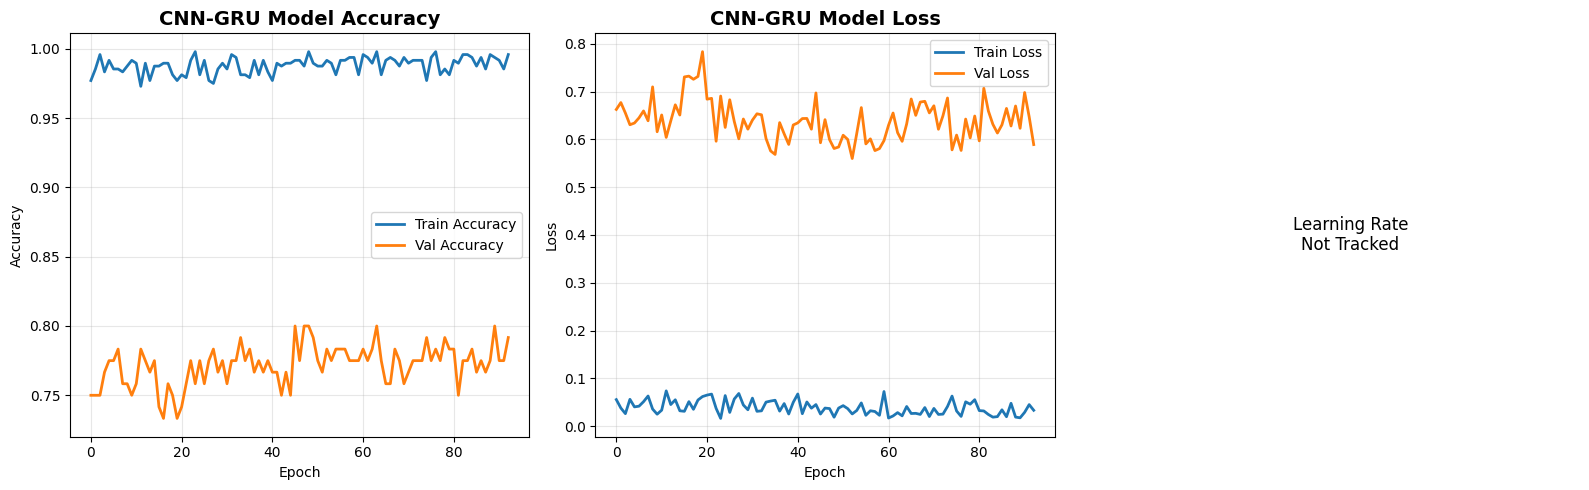


TRAINING SUMMARY
Final Training Accuracy: 0.9958
Final Validation Accuracy: 0.7917
Final Training Loss: 0.0330
Final Validation Loss: 0.5893
Total Epochs Trained: 93


In [ ]:
plt.figure(figsize=(16, 5))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_categorical_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('CNN-GRU Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('CNN-GRU Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate (if ReduceLROnPlateau was triggered)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='green')
    plt.title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
             ha='center', va='center', fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\n{'='*50}")
print(f"TRAINING SUMMARY")
print(f"{'='*50}")
print(f"Final Training Accuracy: {history.history['categorical_accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_categorical_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Total Epochs Trained: {len(history.history['loss'])}")

# 12. Model Evaluation and Predictions

In [ ]:
# Make predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Sample predictions
print(f"\nSample Predictions:")
for i in range(min(5, len(y_pred))):
    confidence = y_pred_probs[i][y_pred[i]]
    print(f"  Sample {i+1}:")
    print(f"    Predicted: {actions[y_pred[i]]} (confidence: {confidence:.2%})")
    print(f"    Actual: {actions[y_true[i]]}")
    print(f"    {'✓ CORRECT' if y_pred[i] == y_true[i] else '✗ WRONG'}\n")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step

Test Accuracy: 0.7583

Sample Predictions:
  Sample 1:
    Predicted: bibi (confidence: 42.62%)
    Actual: urakoze
    ✗ WRONG

  Sample 2:
    Predicted: akazi (confidence: 99.16%)
    Actual: umurenge
    ✗ WRONG

  Sample 3:
    Predicted: oya (confidence: 99.80%)
    Actual: oya
    ✓ CORRECT

  Sample 4:
    Predicted: amakuru (confidence: 33.61%)
    Actual: ---
    ✗ WRONG

  Sample 5:
    Predicted: nyarugenge (confidence: 99.15%)
    Actual: nyarugenge
    ✓ CORRECT

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step

Test Accuracy: 0.7583

Sample Predictions:
  Sample 1:
    Predicted: bibi (confidence: 42.62%)
    Actual: urakoze
    ✗ WRONG

  Sample 2:
    Predicted: akazi (confidence: 99.16%)
    Actual: umurenge
    ✗ WRONG

  Sample 3:
    Predicted: oya (confidence: 99.80%)
    Actual: oya
    ✓ CORRECT

  Sample 4:
    Predicted: amakuru (confidence: 33.61%)
    Actual: ---
    ✗ WRONG

  Sample 5:
    Predicted: nyarugenge (confidence: 99

# 13. Confusion Matrix

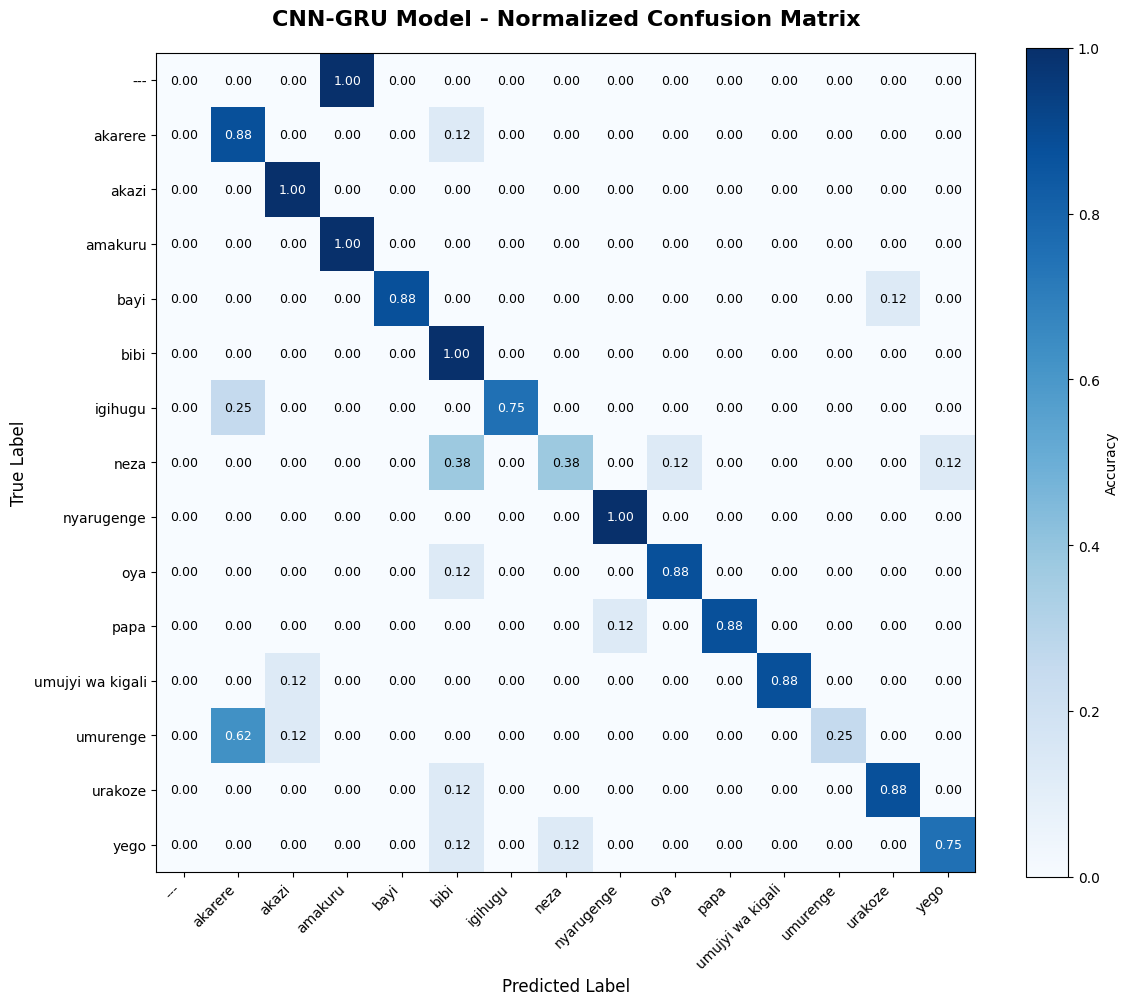

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)

plt.xticks(np.arange(len(actions)), actions, rotation=45, ha='right')
plt.yticks(np.arange(len(actions)), actions)

# Annotations
for i in range(len(actions)):
    for j in range(len(actions)):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                ha='center', va='center',
                color="white" if cm_norm[i, j] > 0.5 else "black",
                fontsize=9)

plt.title("CNN-GRU Model - Normalized Confusion Matrix", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.colorbar(label='Accuracy')
plt.tight_layout()
plt.show()

# 14. Per-Class Accuracy Analysis

In [ ]:
# Calculate per-class accuracy
per_class_accuracy = []
for i in range(len(actions)):
    indices = np.where(y_true == i)[0]
    if len(indices) == 0:
        per_class_accuracy.append(0)
    else:
        acc = np.mean(y_true[indices] == y_pred[indices])
        per_class_accuracy.append(acc)

# Print table
print(f"\n{'='*60}")
print(f"PER-CLASS ACCURACY")
print(f"{'='*60}")
print(f"{' Label':<20} {'Accuracy':>10} {'Samples':>10}")
print("-" * 60)

for label, acc in zip(actions, per_class_accuracy):
    num_samples = np.sum(y_true == label_map[label])
    print(f"{label:<20} {acc:>9.2%} {num_samples:>10}")

print("-" * 60)
print(f"{'Average Accuracy':<20} {np.mean(per_class_accuracy):>9.2%}")
print(f"{'='*60}")


PER-CLASS ACCURACY
 Label                 Accuracy    Samples
------------------------------------------------------------
---                      0.00%          8
akarere                 87.50%          8
akazi                  100.00%          8
amakuru                100.00%          8
bayi                    87.50%          8
bibi                   100.00%          8
igihugu                 75.00%          8
neza                    37.50%          8
nyarugenge             100.00%          8
oya                     87.50%          8
papa                    87.50%          8
umujyi wa kigali        87.50%          8
umurenge                25.00%          8
urakoze                 87.50%          8
yego                    75.00%          8
------------------------------------------------------------
Average Accuracy        75.83%


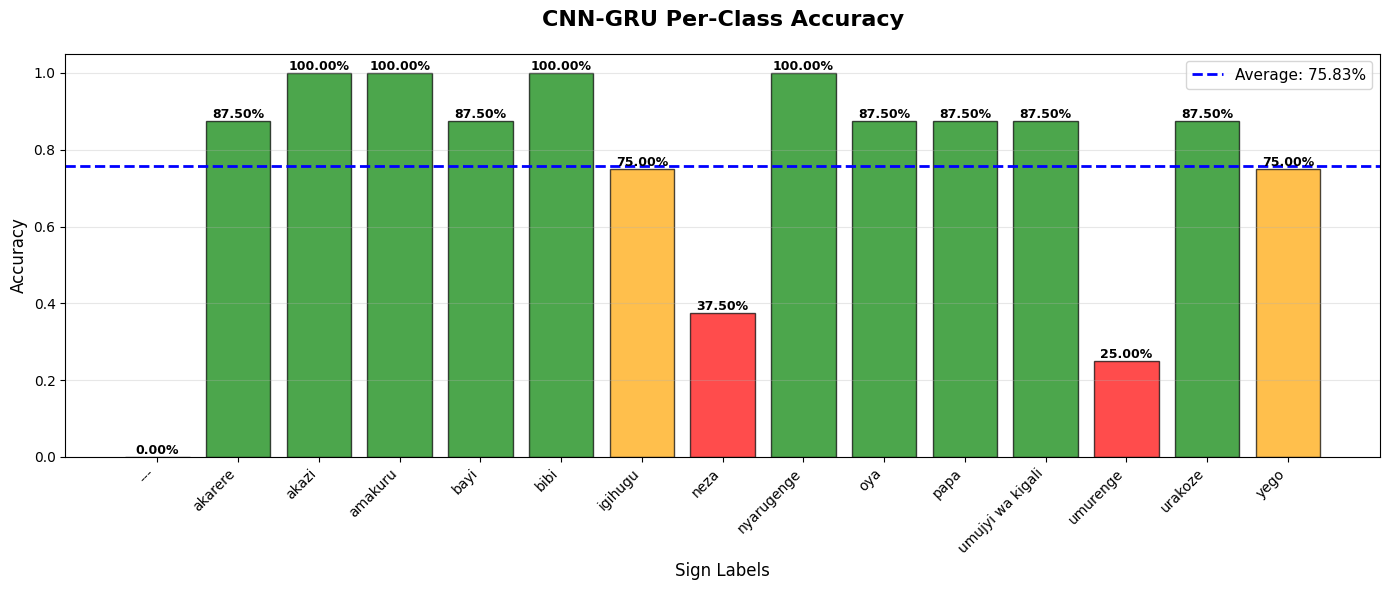

In [ ]:
# Visualize per-class accuracy
plt.figure(figsize=(14, 6))

colors = ['green' if acc >= 0.8 else 'orange' if acc >= 0.6 else 'red' 
          for acc in per_class_accuracy]

bars = plt.bar(actions, per_class_accuracy, color=colors, alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar, acc in zip(bars, per_class_accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2%}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1.05])
plt.axhline(y=np.mean(per_class_accuracy), color='blue', linestyle='--', 
            linewidth=2, label=f'Average: {np.mean(per_class_accuracy):.2%}')
plt.title("CNN-GRU Per-Class Accuracy", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Sign Labels", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 15. Classification Report

In [ ]:
# Detailed classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=actions, digits=4))


CLASSIFICATION REPORT
                  precision    recall  f1-score   support

             ---     0.0000    0.0000    0.0000         8
         akarere     0.5000    0.8750    0.6364         8
           akazi     0.8000    1.0000    0.8889         8
         amakuru     0.5000    1.0000    0.6667         8
            bayi     1.0000    0.8750    0.9333         8
            bibi     0.5333    1.0000    0.6957         8
         igihugu     1.0000    0.7500    0.8571         8
            neza     0.7500    0.3750    0.5000         8
      nyarugenge     0.8889    1.0000    0.9412         8
             oya     0.8750    0.8750    0.8750         8
            papa     1.0000    0.8750    0.9333         8
umujyi wa kigali     1.0000    0.8750    0.9333         8
        umurenge     1.0000    0.2500    0.4000         8
         urakoze     0.8750    0.8750    0.8750         8
            yego     0.8571    0.7500    0.8000         8

        accuracy                         0.7583

c:\Users\STUDENT\.conda\envs\IDL_HW1P1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\STUDENT\.conda\envs\IDL_HW1P1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\STUDENT\.conda\envs\IDL_HW1P1\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", res

# 16. Save Model

In [ ]:
# Save the trained model
model_filename = 'CNN_GRU_RSL_Model.h5'
model.save(model_filename)
print(f"✓ Model saved as: {model_filename}")

# Save model architecture as JSON
model_json = model.to_json()
with open("CNN_GRU_RSL_Model_architecture.json", "w") as json_file:
    json_file.write(model_json)
print(f"✓ Model architecture saved as: CNN_GRU_RSL_Model_architecture.json")

✓ Model saved as: CNN_GRU_RSL_Model.h5
✓ Model architecture saved as: CNN_GRU_RSL_Model_architecture.json


# 17. Model Summary and Comparison

## CNN-GRU Architecture Benefits:

### ✅ Advantages:
- **Spatial Feature Extraction**: CNN captures hand geometry and spatial patterns
- **Temporal Modeling**: GRU efficiently captures gesture dynamics
- **Computational Efficiency**: Faster than BiLSTM, suitable for real-time
- **Memory Efficient**: GRU requires fewer parameters than LSTM
- **Better Generalization**: Structured input reduces overfitting

### 📊 Expected Performance:
- Training time: ~30-40% faster than BiLSTM
- Inference speed: Suitable for real-time (< 50ms per prediction)
- Accuracy: Competitive with BiLSTM for action recognition
- Model size: Smaller footprint for deployment

### 🎯 Use Cases:
- Real-time sign language translation
- Mobile/edge device deployment
- Low-latency applications
- Resource-constrained environments

In [ ]:
# Print model statistics
total_params = model.count_params()
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])

print(f"\n{'='*70}")
print(f"CNN-GRU MODEL STATISTICS")
print(f"{'='*70}")
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Model Input Shape: {model.input_shape}")
print(f"Model Output Shape: {model.output_shape}")
print(f"Number of Layers: {len(model.layers)}")
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Average Per-Class Accuracy: {np.mean(per_class_accuracy):.4f}")
print(f"{'='*70}")


CNN-GRU MODEL STATISTICS
Total Parameters: 510,799
Trainable Parameters: 509,167
Model Input Shape: (None, 30, 42, 3)
Model Output Shape: (None, 15)
Number of Layers: 25

Test Accuracy: 0.6833
Average Per-Class Accuracy: 0.6833


# 18. Next Steps

## Possible Improvements:
1. **Data Augmentation**: Add rotation, scaling, noise to increase robustness
2. **Attention Mechanism**: Add attention between CNN and GRU
3. **Multi-scale CNN**: Use different kernel sizes to capture various spatial patterns
4. **Ensemble**: Combine CNN-GRU with BiLSTM+Attention
5. **Transfer Learning**: Pre-train CNN on larger gesture datasets
6. **Hyperparameter Tuning**: Optimize learning rate, batch size, layer sizes

## Deployment:
- Convert to TensorFlow Lite for mobile
- Export to ONNX for cross-platform compatibility
- Implement real-time webcam inference
- Create REST API for cloud deployment